In [331]:
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

columnwidth = 342.2953 # value given by Latex

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

# Singular Value Decomposition (SVD) Basics

1. Intro to SVD (...and where is it used in computational quantum matter?)

2. Dimensionality reduction of Congressional Voting Records

3. Classification and Polarization Measures

Here we will review some powerful, fundamental linear algebra basics to solve overcomplete and undercomplete matrix regression problems. Fundamentally if I have a system of $n$ linearly independent equations and $n$, variables I can simply perform an eigendecomposition to solve the problem. If the problem were so naively presented as:

\begin{align}
    x^2 + 4y^3 + z &= a_1 \\
    x + y &= a_2 \\
    x &= a_3
\end{align}

I have three varialbes $[x, y, z]$ and can perform reverse substitution here to solve the full problem given three coefficients $[a_1, a_2, a_3]$. Now if I were given undercomplete information, I would only have the first two equations and would arive at a general function $z(x,y) = something... $ so I have infinite solutions but with a constraint. If I have overcomplete information, that means I have equations that are not linearly independent or I have an inconsistency. Adding $x = a_4$ would be such an example of an overcomplete situation.


Returning to general matrix equation, I want to work with non-square matrices and be able to determine the constraints applied to whatever relevant variables I have. In some sense I want to come up with these constraints such that at the end of the day I can apply some meaningful classification to infer a trend or collective behavior.


In this notebook we will be working with roll call votes from the awesome dataset provided by: https://voteview.com/articles/data_help_rollcalls

Let's import the .csv file to a Pandas Dataframe, understand the catagories, clean up the data, and finally perform our SVD analysis.

In [388]:
hs15 = pd.read_csv("Desktop/HS115_votes.csv");
hs15.head()

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,115,House,1,10713.0,6,100.0
1,115,House,1,14066.0,1,98.9
2,115,House,1,14263.0,6,100.0
3,115,House,1,14657.0,1,98.9
4,115,House,1,14854.0,1,99.8


## ***Comment***

The data is separated into 6 columns. There is an extensive amount of analysis that went into gathering the data and some of the columns depend on this. The columns are detiled as (identically presented in https://voteview.com/articles/data_help_votes)

1. congress: Session of Congress (integer)
2. chamber: Legislative branch (House or Senate, string)
3. rollnumber: number of vote during the particular congressional period.
4. icpsr: unique identifier for each congress-person (new number for new party affiliation)
5. cast_code: Encoding scheme for how icpsr voted on the rollnumber. See link for decoding
6. prob: "Estimated probability, based on NOMINATE, of the member making the vote as recorded." (not worried about)

So the data we want is [number of unique icpsr x vote outcome for each issue]. Therefore the size of the matrix we will use for each Congressional session will be num(unique(icpsr)) x max(rollnumber). This will give us an $c \times v$ matrix of data (c: congress person, v: votes). We want to reduce the dimensionality of this dataset to classify the individual vectors of each senator as well as understand how simple the dataset can be compressed. We want to define two orthogonal vectors and then observe how the $c-$congress people fall onto the map.

First things first, we need to reorganize the dataset, rows are the votes and columns are the different representatives. Let's also restrict ourselves to just working with the Senate.

In [389]:
senate_15 = hs15.loc[hs15['chamber'] == 'Senate'];
house_15 = hs15.loc[hs15['chamber'] == 'House'];

senate_15 = senate_15.sort_values(by = ['rollnumber', 'icpsr']);

roll_senate_max = np.max(senate_15['rollnumber'].to_numpy());
unique_senate = np.size(np.unique(senate_15['icpsr'].to_numpy()));

In [314]:
uni_sen_vals = senate_15['icpsr'].unique();
uni_sen_vals = np.sort(uni_sen_vals);

senate_15.replace(to_replace=uni_sen_vals,
           value= list(range(len(uni_sen_vals))),
           inplace=True)

senate_15['cast_code'] = senate_15['cast_code'].replace(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
    [0, 1, 1, 1, -1, -1, -1, 0, 0, 0])

***Recasting voting data:*** The votes are identified by integers $i \in [0,9]$, where the meaning is provided by voteview.com. In [7] We assign values that are affirmative for the issue, against, and abstain/not present as $(1, -1, 0)$, respectively. 

In [3] we replace each senator's unique label with a simple integer so we can quickly assign vote values to the senator votes matrix.


Now for each vote we can assign the $c-$ dimensional vector of senator votes. We will also remove columns of senators where the senator voted on less than half of the issues.

In [315]:
sen_matrix = np.zeros([roll_senate_max, unique_senate]);

rolls = senate_15['rollnumber'].to_numpy();
senators = senate_15['icpsr'].to_numpy(dtype=int)
votes = senate_15['cast_code'].to_numpy()

for i in range(len(rolls)):
    sen_matrix[rolls[i] - 1][senators[i]] = votes[i];

to_delete = [];


for i in range(unique_senate):
    '''Find rows with absolute sum less than number of issues divided by 2.'''
    if np.sum(np.abs(sen_matrix[:,i])) < roll_senate_max // 2:
        to_delete.append(i);
        
sen_matrix = np.delete(sen_matrix, to_delete, 1);

In [316]:
#Perform SVD on the senator voting matrix

U, S, Vt = svd(sen_matrix.T);

print(U.shape, S.shape, Vt.shape)

(98, 98) (98,) (599, 599)


## Understanding SVD

Given a matrix $M \in [c \times v]$ with columns denoted by congress-people by votes, we get three matrices $U, S, V^T$. The matrices are the following:

1. $U$: Unitary matrix made of $c$ principal columns, left singular vectors
2. $S$: Singular values (eigenvalues) of the matrix $MM^T$
3. $V$: Unitary matrix made of $v$ columns, right singular vectors.

The singular values provide a measure of how easily the data can be compressed. For the number of nonzero eigenvalues $s < |S|$, the system can be exactly recreated by only keeping the $s$ left + right principle vectors. The total number of elements that then need to be saved is $c \times s + s + s \times n$. So for $s << \text{min}(c, v)$ the data can be severely compressed; where, such methods are useful for simulating weakly entangled quantum systems (weakly entangled means having few nonzero eigenvalues) where vectors of size $2^N$ can be compressed into $2N$ elements in the most optimal conditions (EXPONENTIAL REDUCTION IN MEMORY REQUIREMENTS!!!).

If we want to understand how well we can approximate the original data, the reduced dimensionality data can be calculated as $U[:, :s] \times S[:s, :s] \times V^T[:s, :]$ gives us a $c \times v$ matrix but only has rank $s$, or $s$ nonzero eigenvalues.

Here we are interested in understanding how well the voting data can be approximated in the $2-$dimensional plane. With such a simple dimensionality reduction, we want to understand how well the two dominant principal components are capable of clustering the data and if linear relationships can be established between various congress-persons.

The principal components of the data are just

\begin{equation}
    C_i = U^T_i \cdot S_i,
\end{equation}

where $U^T_i$ is the ith column of $U$ and the ith singular value of the decomposition. We will then plot $s_1U^T_1$ vs. $s_2U^T_2$.

In [317]:
#Reproduce the original dataset after reducing the dimensionality to size {dim}
dim = 3;

eigs = np.diag(S)

dimRed = U[:,:dim] @ eigs[:dim, :dim] @ Vt[:dim, :];

print("(Compression-Decompression Size) Relative error:")
print(dimRed.shape, np.sum(((sen_matrix.T @ sen_matrix)/S.sum() - (dimRed @ dimRed.T)/S.sum())**2.0)/S.sum())

(Compression-Decompression Size) Relative error:
(98, 599) 0.0013040528321214859


Text(0, 0.5, '$s_{II}U_{II}$')

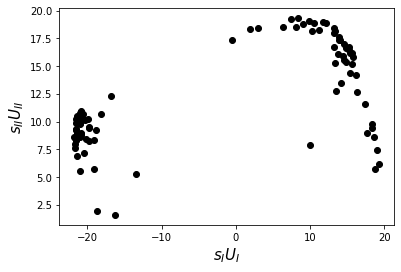

In [318]:
plt.scatter(U[:,0] * S[0], U[:,1] * S[1], color = 'k')
#plt.ylim(-25, 5);
#plt.xlim(-20, 21)
plt.xlabel(r'$s_I U_I$', fontsize = 15)
plt.ylabel(r'$s_{II}U_{II}$', fontsize = 15)

Great! We have reduced the dimensionality of the data and scatter plotted the results. There look to be two very obvious clusters. We haven't assigned any classification to the data so who knows what's what.

Voteview.com supplies information regarding each congress-persons idealogical affiliation so we can then import that data to assign the color.

In [319]:
parties = pd.read_csv("Desktop/HSall_members_ideology.csv");
parties15 = parties.loc[parties['congress'] == 115];

parties15 = parties15.sort_values(by = 'icpsr');

codes = parties15.loc[parties15['icpsr'].isin(uni_sen_vals)]['party_code'].replace(
    [100, 200, 328], 
    ['blue', 'red', 'green']).to_numpy()

codes = np.delete(codes, to_delete)
parties15.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
48484,115,House,10713,23,13.0,MI,100,NaN,NaN,"CONYERS, John, Jr.",...,2019.0,-0.658,-0.512,-33.52608,0.93881,531.0,15.0,NaN,-0.601,-0.337
48782,115,Senate,14009,46,0.0,MS,200,NaN,NaN,"COCHRAN, William Thad",...,2019.0,0.287,0.051,-8.71480,0.97263,314.0,0.0,NaN,0.368,0.244
48289,115,House,14066,81,1.0,AK,200,NaN,NaN,"YOUNG, Donald Edwin",...,NaN,0.283,0.021,-204.70592,0.80166,926.0,91.0,NaN,0.277,0.315
48763,115,Senate,14226,31,0.0,IA,200,NaN,NaN,"GRASSLEY, Charles Ernest",...,NaN,0.349,-0.069,-47.23710,0.91348,522.0,19.0,NaN,0.459,-0.055
48499,115,House,14263,33,8.0,MN,100,NaN,NaN,"NOLAN, Richard Michael",...,NaN,-0.372,-0.372,-164.80005,0.82939,881.0,80.0,NaN,-0.360,0.096


Text(0.5, 0, '$s_1 U_1$')

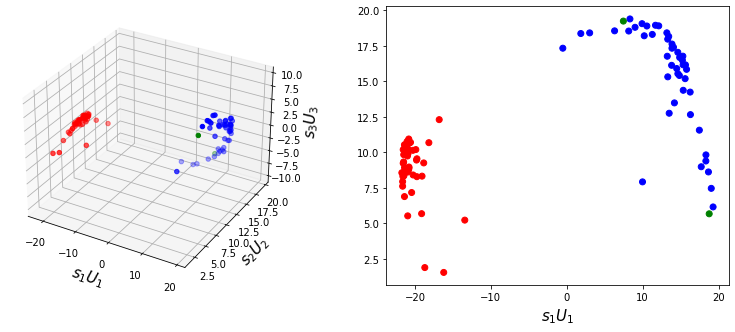

In [357]:
fig = plt.figure(figsize=get_figsize(columnwidth,wf=2.85,hf=0.38));

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(U[:,0] * S[0], U[:,1] * S[1], U[:,2] * S[2], color = codes)
#plt.ylim(-25, 5);
#plt.xlim(-20, 21)
ax.set_xlabel(r'$s_1 U_1$', fontsize = 15)
ax.set_ylabel(r'$s_{2}U_{2}$', fontsize = 15)
ax.set_zlabel(r'$s_{3}U_{3}$', fontsize = 15)

ax = fig.add_subplot(1, 2, 2)

ax.scatter(U[:,0] * S[0], U[:,1] * S[1], color = codes)
#plt.ylim(-25, 5);
#plt.xlim(-20, 21)
ax.set_xlabel(r'$s_1 U_1$', fontsize = 15)
#ax.set_ylabel(r'$s_{2}U_{2}$', fontsize = 15)

## Discussion:

And wow, there we have it. Once we can color code the data (and add a third axis), we see a stark separation in the Democratic vs. Republican set. We could easily draw contours to *classify* the data but for the time being will leave that for later. The next question we are going to tackle is: **How has this developed over time**. A longer term question would be is this polarization inherent to the party or does it grow as a function of age (older senators more polarized than younger over time, younger senators start more/less polarized etc.).

Let's start with just investigating the same political polarization over the years 1940-2020.

In [405]:
def SVD_senates(senate_df, parties_df, session, compress=3, vecs=3):
    """Return SVD Data and Relative Compression error for Senate Vote Data
    
    Parameters:
      - senate_df [pandas.DataFrame]:  Dataframe containing Senator voting results 
                                       formatted according to voteview.com. Contains
                                       session of congress, congress-person identifiers,
                                       yea/nay votes.
                                       
      - parties_df [pandas.DataFrame]: Dataframe containing Senators' political party 
                                       affiliation.
      
      - session [int]:  Session of congress to analyze voting records
      
      - compress [int]: Number of principal vectors to keep when compressing the data
      
      - vecs [int]: Number of principal Senator vectors to return.
      
    Returns:  [U[:, :vecs] , S[:vecs] , Party, Acc]: SVD (USVt) of senator voting matrix,
                                                     party affiliation of the senators ordered
                                                     according to columns, and relative error 
                                                     when compressing the data with [compress] 
                                                     number of principal vectors.
    """
    
    senate = senate_df.loc[senate_df['congress'] == session];
    senate = senate.sort_values(by = ['rollnumber', 'icpsr']);

    roll_senate_max = np.max(senate['rollnumber'].to_numpy());
    unique_senate = np.size(np.unique(senate['icpsr'].to_numpy()));
    
    uni_sen_vals = senate['icpsr'].unique();
    uni_sen_vals = np.sort(uni_sen_vals);

    senate.replace(to_replace=uni_sen_vals,
               value= list(range(len(uni_sen_vals))),
               inplace=True)
    
    senate['cast_code'] = senate['cast_code'].replace(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
        [0, 1, 1, 1, -1, -1, -1, 0, 0, 0])
    
    sen_matrix = np.zeros([roll_senate_max, unique_senate]);

    rolls = senate['rollnumber'].to_numpy();
    senators = senate['icpsr'].to_numpy(dtype=int)
    votes = senate['cast_code'].to_numpy()

    for i in range(len(rolls)):
        sen_matrix[rolls[i] - 1][senators[i]] = votes[i];

    to_delete = [];

    for i in range(unique_senate):
        '''Find rows with absolute sum less than number of issues divided by 2.'''
        if np.sum(np.abs(sen_matrix[:,i])) < roll_senate_max // 2:
            to_delete.append(i);

    sen_matrix = np.delete(sen_matrix, to_delete, 1);
    
    # Perform SVD
    U, S, Vt = svd(sen_matrix.T);
    
    #Calculate Dimensionality Reduction
    eigs = np.diag(S)
    dimRed = U[:,:compress] @ eigs[:compress, :compress] @ Vt[:compress, :];
    
    Acc = np.sum(((sen_matrix.T @ sen_matrix)/S.sum() - (dimRed @ dimRed.T)/S.sum())**2.0)/S.sum()
    
    #Extract Party Affiliation
    part = parties_df.loc[parties_df['congress'] == session];
    part = part.sort_values(by = 'icpsr').drop_duplicates(subset=['icpsr']);
    
    codes = part.loc[part['icpsr'].isin(uni_sen_vals)]['party_code'].replace(
        [100, 200, 328], 
        ['blue', 'red', 'green']).to_numpy()
    
    
    codes = np.delete(codes, to_delete)
    
    for j in range(len(codes)):
        if type(codes[j]) != str:
            codes[j] = 'orange';
    return U[:, :vecs], S[:vecs], codes, Acc;

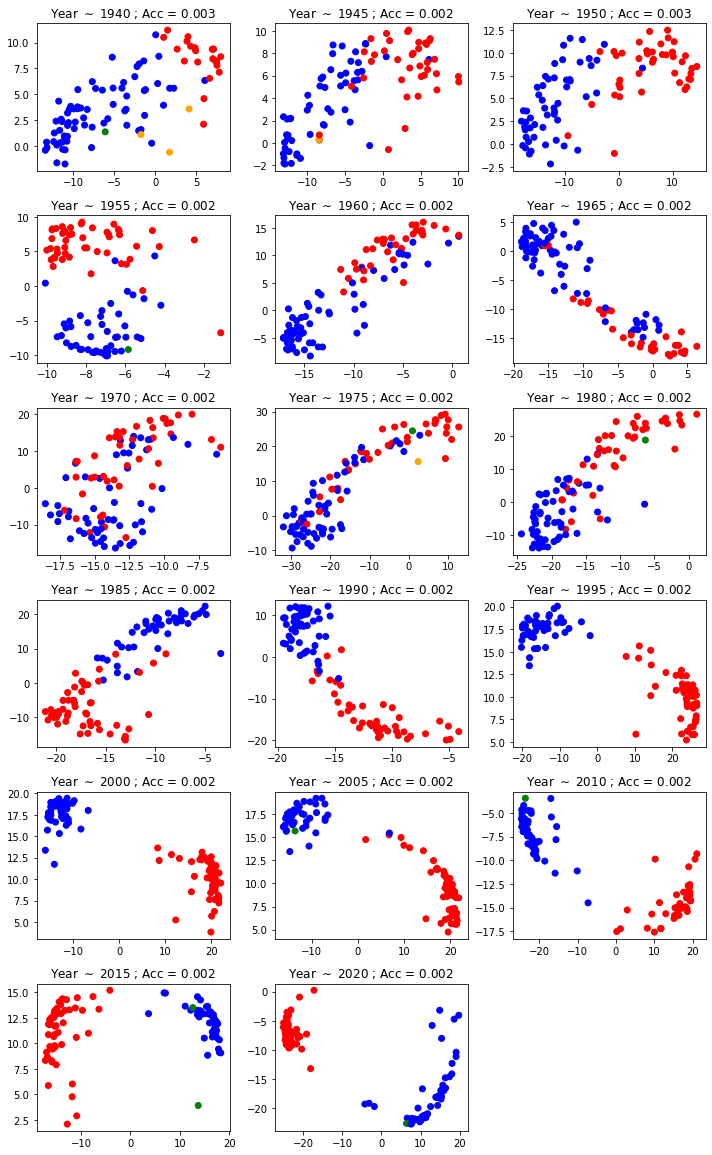

In [408]:
YEARS = np.arange(1940, 2021, 5,dtype=int);
SESSIONS = (YEARS - 1787) // 2;

compression_acc = np.zeros([len(SENATES)]);

full_senate = pd.read_csv("Desktop/HSall_votes_members.csv");
full_senate = full_senate.loc[full_senate['chamber'] == 'Senate'];

fig = plt.figure(figsize=(10, 1.25*len(SESSIONS)))

for i,session in enumerate(SESSIONS):
    
    U,S, codes, Acc = SVD_senates(full_senate, parties, session);
    
    ax = fig.add_subplot(int(len(SESSIONS)/2), 3, i+1);
    ax.scatter(U[:,0] * S[0], U[:,1] * S[1], color = codes)
    ax.set_title(r"Year $\sim$ %1.0d ; Acc = %0.3f" % (YEARS[i], Acc));
    
fig.tight_layout()